Following is research data for investigating the disease situation in a given area. This research recruits volunteers who must be at least 40 years old.


In [1]:
#%pip install matplotlib

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt


# There are two files containing the patient's information

Patient_information:

In [2]:
patientInfoURL= "https://raw.githubusercontent.com/WHPAN0108/BHT-DataScience-S24/main/data_clean/data/patient_info.csv"
#"https://github.com/WHPAN0108/BHT-DataScience-S24/blob/main/data_clean/data/patient_info.csv"


- Patient_ID: numeric the patient id with 7 digits
- Sex: string Male or Female
- Age: numeric The Age of recruitment
- BMI: numeric Body Mass Index, should be between 15-60
- Smoking_status: string Never, Previous, current, Prefer not to answer
- Disease: factor 1 means disease, 2 means healthy


In [3]:
dateURL= "https://raw.githubusercontent.com/WHPAN0108/BHT-DataScience-S24/main/data_clean/data/date.csv"
#"https://github.com/WHPAN0108/BHT-DataScience-S24/blob/main/data_clean/data/date.csv"


Hosptial Visit:
- Patient_ID: numeric the patient id with 7 digits
- VisitDate: Date, the date of the patient's visit hospital. the data is collected from the year 1950 to 2023


In [4]:
patientInfo = pd.read_csv(patientInfoURL, delimiter=',')


# Task : Data Clean & EDA



- Replace missing BMI values with the median BMI for the corresponding gender.

In [5]:
# -> columns with missing values: Smoking_status, BMI, Disease
males = patientInfo[patientInfo['Sex'] == "Male"]
females = patientInfo[patientInfo['Sex'] == "Female"]
# i first tested if all rows either are Sex=Male or Sex=Female by comparing the counts of the entire dataset with the sum of the counts of the two subsets
# print(patientInfo.count())
# print (males["Sex"].count())
# print (females["Sex"].count())
maleBmiMedian = males["BMI"].median()
femaleBmiMedian = females["BMI"].median()
patientInfo1 = patientInfo.copy()

def cleanBMI(x):
    if pd.isna(x["BMI"]): # took me a while to figure out to use .isna() instead of == np.nan
        x["BMI"]=maleBmiMedian if x["Sex"] == "Male" else femaleBmiMedian
    return x

#  apparently, apply creates a copy.
patientInfoFilledBMI = patientInfo.apply(cleanBMI, axis=1)

# print(patientInfoCleanedBMI.count())
# print(patientInfo.count())
patientInfoFilledBMI


,Participant_ID,Sex,Age,Smoking_status,BMI,Disease
0,1003300,Male,62,Previous,33.7597,2
1,1004025,Male,60,Previous,28.1173,1
2,1005551,Male,69,Previous,26.4159,2
3,1005594,Male,64,Previous,24.7550,1
4,1005624,Male,64,Previous,35.0773,2
...,...,...,...,...,...,...
2211,6009769,Male,48,Previous,39.3345,2
2212,6011693,Male,62,Previous,30.8813,2
2213,6015403,Female,60,Previous,34.7276,1
2214,6019982,Male,54,Never,25.3287,2


- Perform a sanity check on all columns in both files, and remove any samples that do not pass.

In [6]:
print(
    [patientInfoFilledBMI["Sex"].unique(),
    # just a sanity check.
    np.sort(patientInfoFilledBMI["Age"].unique()),
    # the age of 6 is probably a typo. I will remove it.
    patientInfoFilledBMI["Smoking_status"].unique(),
    # the smoking status of "nan" is an outlier. I will remove it.
    patientInfoFilledBMI["BMI"].max(),
    # a BMI of > 100 feels wrong. I will remove it.
    patientInfoFilledBMI["BMI"].min(),
    np.sort(patientInfoFilledBMI["BMI"]),
    # a negative BMI is impossible. I will remove it.
    patientInfoFilledBMI["Disease"].unique()]
    # there's only two values for Desease: 1 and 2. I will keep them.
    )

patientInfoClearedAge = patientInfoFilledBMI.drop(patientInfoFilledBMI[patientInfoFilledBMI["Age"] == 6].index)
#np.sort(patientInfoClearedAge["Age"].unique())
patientInfoCleanedSmokingStatus = patientInfoClearedAge.drop(patientInfoClearedAge[patientInfoClearedAge["Smoking_status"].isna()].index)
# patientInfoCleanedSmokingStatus["Smoking_status"].unique(),
patientInfoCleanedBmi = patientInfoClearedAge.drop(patientInfoClearedAge[patientInfoClearedAge["BMI"] < 15].index)
patientInfoClearedBmi = patientInfoCleanedBmi.drop(patientInfoCleanedBmi[patientInfoCleanedBmi["BMI"] > 60].index)
#np.sort(patientInfoClearedBmi["BMI"])


dateData = pd.read_csv(dateURL, delimiter=',')
# there are a couple of rows with missing values in the VisitDate column. I will remove them.
dateDataCleaned = dateData.drop(dateData[dateData["VisitDate"].isna()].index)
#dateDataCleaned.count()
# we should remove the "date" rows referring to participants that are not in the patientInfoClearedBmi dataset.

dateDataCleared = dateDataCleaned[dateDataCleaned["Participant_ID"].isin(patientInfoClearedBmi["Participant_ID"])]
dateDataCleared.count()



[array(['Male', 'Female'], dtype=object), array([ 6, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
       56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70],
      dtype=int64), array(['Previous', 'Never', 'Current', 'Prefer not to answer', nan],
      dtype=object), 100.357, -31.4133, array([-31.4133,  16.0037,  16.0995, ...,  53.4857,  58.9468, 100.357 ]), array([2, 1], dtype=int64)]


Participant_ID    2800
VisitDate         2800
dtype: int64

- Calculate the number of visits each patient made since 1/1/2020. If the VisitDate is missing, it indicates no visits during this period.

In [7]:
def countVisitsAfter2020(x):
    count = 0;
    for i in x["VisitDate"]:
        if pd.to_datetime(i, format='mixed', dayfirst=True) > pd.to_datetime("1/1/2020"):
            count += 1
    return count
visitsAfter2020 = dateDataCleared.groupby("Participant_ID").apply(countVisitsAfter2020)
visitsAfter2020

C:\Users\Alexa\AppData\Local\Temp\ipykernel_26436\2672114181.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  visitsAfter2020 = dateDataCleared.groupby("Participant_ID").apply(countVisitsAfter2020)


Participant_ID
1003300    2
1004025    0
1005551    2
1005594    1
1005624    1
          ..
6009769    0
6011693    2
6015403    0
6019982    0
6020094    2
Length: 2130, dtype: int64


- Create a summary table and/or chart showing the number of visits for each month (irrespective of the year).

In [8]:
dateDataCleared["Month"] = dateDataCleared["VisitDate"].apply(lambda x: pd.to_datetime(x, format='mixed', dayfirst=True).month)
dateDataCleared.groupby("Month").count()
# this is a sufficient Summary table, isn't it? if i find the time, i will create a plot.

C:\Users\Alexa\AppData\Local\Temp\ipykernel_26436\298523749.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dateDataCleared["Month"] = dateDataCleared["VisitDate"].apply(lambda x: pd.to_datetime(x, format='mixed', dayfirst=True).month)


,Participant_ID,VisitDate
Month,,
1,247,247
2,202,202
3,217,217
4,221,221
5,260,260
6,255,255
7,250,250
8,249,249
9,209,209



- add a new column "age group " to split the age to 5 categories:  40-49, 50-59, 60-69, and above 70)


In [9]:
patientInfoClearedBmi["age group"] = patientInfoClearedBmi["Age"].apply(lambda age: 
    "40-49" if age < 50 else 
    "50-59" if age < 60 else 
    "60-69" if age < 70 else 
    "70")
patientInfoClearedBmi

,Participant_ID,Sex,Age,Smoking_status,BMI,Disease,age group
0,1003300,Male,62,Previous,33.7597,2,60-69
1,1004025,Male,60,Previous,28.1173,1,60-69
2,1005551,Male,69,Previous,26.4159,2,60-69
3,1005594,Male,64,Previous,24.7550,1,60-69
4,1005624,Male,64,Previous,35.0773,2,60-69
...,...,...,...,...,...,...,...
2211,6009769,Male,48,Previous,39.3345,2,40-49
2212,6011693,Male,62,Previous,30.8813,2,60-69
2213,6015403,Female,60,Previous,34.7276,1,60-69
2214,6019982,Male,54,Never,25.3287,2,50-59


- Merge the two files to include the columns: Patient_ID, Sex, Age, BMI, Smoking_status, Number_of_visits, Disease and age group

In [10]:
dateDataMerge = dateDataCleared.groupby("Participant_ID").count().astype(int)
dateDataMerge
#merged = patientInfoClearedBmi.copy()
#merged["Visits"] = dateDataMerge["VisitDate"]["count"]
merged= patientInfoClearedBmi.join(dateDataMerge, on="Participant_ID")
merged.drop(columns=["Month"], inplace=True)
merged.rename(columns={"VisitDate": "Number_of_visits", "Participant_ID": "Patient_ID"}, inplace=True)
merged["Number_of_visits"] = merged["Number_of_visits"].fillna(0)
merged["Number_of_visits"] = merged["Number_of_visits"].astype(int)
merged

,Patient_ID,Sex,Age,Smoking_status,BMI,Disease,age group,Number_of_visits
0,1003300,Male,62,Previous,33.7597,2,60-69,2
1,1004025,Male,60,Previous,28.1173,1,60-69,1
2,1005551,Male,69,Previous,26.4159,2,60-69,2
3,1005594,Male,64,Previous,24.7550,1,60-69,1
4,1005624,Male,64,Previous,35.0773,2,60-69,2
...,...,...,...,...,...,...,...,...
2211,6009769,Male,48,Previous,39.3345,2,40-49,1
2212,6011693,Male,62,Previous,30.8813,2,60-69,4
2213,6015403,Female,60,Previous,34.7276,1,60-69,1
2214,6019982,Male,54,Never,25.3287,2,50-59,1




# Task: Statistics (you don't need to check the model assumption in this exercise)

- Compare the BMI between the healthy and control groups using a box or violin plot.


<Axes: title={'center': 'BMI distribution by Disease1'}, xlabel='Disease', ylabel='BMI'>

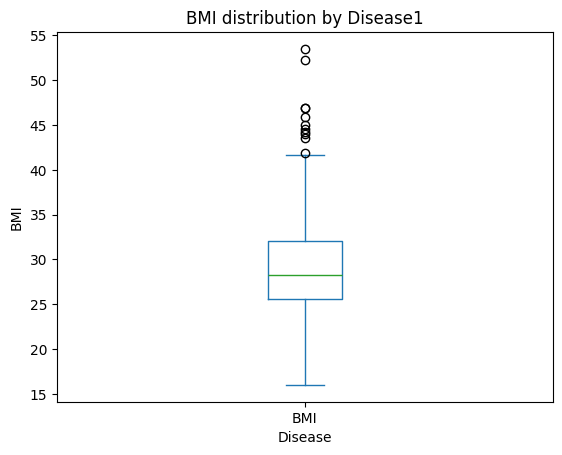

In [23]:
merged[merged["Disease"] == 1]["BMI"].plot(kind="box", title="BMI distribution by Disease1", ylabel="BMI", xlabel="Disease", legend=True)

<Axes: title={'center': 'BMI distribution by Disease2'}, xlabel='Healthy', ylabel='BMI'>

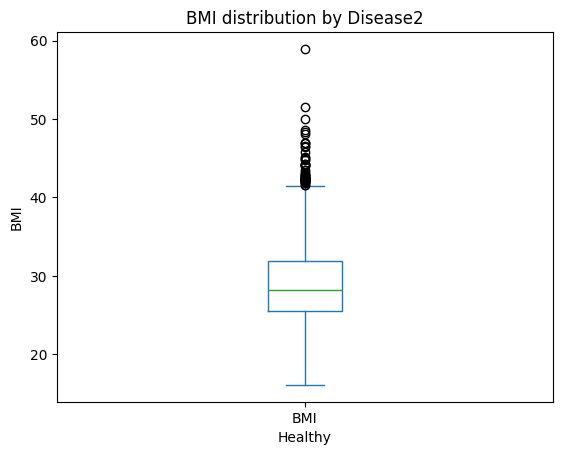

In [24]:
merged[merged["Disease"] == 2]["BMI"].plot(kind="box", title="BMI distribution by Disease2", ylabel="BMI", xlabel="Healthy", legend=True)

- Examine if the proportion of smoking status differs between the healthy and control groups.


In [145]:
merged.groupby(["Disease", "Smoking_status"] ).count()

Patient_ID  Sex  Age  BMI  age group  \
Disease Smoking_status                                               
1       Current                       92   92   92   92         92   
        Never                        214  214  214  214        214   
        Prefer not to answer           5    5    5    5          5   
        Previous                     254  254  254  254        254   
2       Current                      258  258  258  258        258   
        Never                        635  635  635  635        635   
        Prefer not to answer           4    4    4    4          4   
        Previous                     748  748  748  748        748   

                              Number_of_visits  
Disease Smoking_status                          
1       Current                             92  
        Never                              214  
        Prefer not to answer                 5  
        Previous                           254  
2       Current                            258  
        Never                              635  
        Prefer not to answer                 4  
        Previous                           748

- Analyze the relationship between smoking status and the number of hospital visits, separately for the disease and healthy groups, and for the overall population.


In [164]:
def analyzeSmokingStatus(x):
    print([x.groupby("Smoking_status")["Number_of_visits"].sum(), x.groupby("Smoking_status")["Number_of_visits"].sum() / x["Number_of_visits"].sum()])

analyzeSmokingStatus(merged)
analyzeSmokingStatus(merged[merged["Disease"] == 1])
analyzeSmokingStatus(merged[merged["Disease"] == 2])
#print(merged.groupby("Smoking_status")["Number_of_visits"].sum() / merged["Number_of_visits"].sum())
#print(merged[["Desease" == 1]].groupby("Smoking_status")["Number_of_visits"].sum() / merged["Desease" == 1]["Number_of_visits"].sum())

[Smoking_status
Current                  455
Never                   1064
Prefer not to answer      12
Previous                1265
Name: Number_of_visits, dtype: int32, Smoking_status
Current                 0.162500
Never                   0.380000
Prefer not to answer    0.004286
Previous                0.451786
Name: Number_of_visits, dtype: float64]
[Smoking_status
Current                 124
Never                   280
Prefer not to answer      7
Previous                307
Name: Number_of_visits, dtype: int32, Smoking_status
Current                 0.172702
Never                   0.389972
Prefer not to answer    0.009749
Previous                0.427577
Name: Number_of_visits, dtype: float64]
[Smoking_status
Current                 331
Never                   784
Prefer not to answer      5
Previous                958
Name: Number_of_visits, dtype: int32, Smoking_status
Current                 0.158982
Never                   0.376561
Prefer not to answer    0.002402
Previous  

- Determine if the number of visits is higher in the disease group compared to the healthy group.


In [184]:
print(merged.groupby("Disease")["Patient_ID"].count())
print(merged.groupby("Disease")["Number_of_visits"].sum())
print(merged.groupby("Disease")["Number_of_visits"].sum() / merged.groupby("Disease")["Patient_ID"].count())
# the number of visits per patient is higher for patients with disease 2 than for patients with disease 1.

Disease
1     565
2    1648
Name: Patient_ID, dtype: int64
Disease
1     718
2    2082
Name: Number_of_visits, dtype: int32
Disease
1    1.270796
2    1.263350
dtype: float64


- Calculate the disease prevalence (number of sick  / total number population) across different age groups  in our dataset, and test if the prevalence is different across the group


In [183]:
print(merged.groupby(["age group", "Disease"])["Patient_ID"].count())
print(merged.groupby(["age group"])["Patient_ID"].count())
print(merged.groupby(["age group", "Disease"])["Patient_ID"].count() / merged.groupby(["age group"])["Patient_ID"].count())

age group  Disease
40-49      1            42
           2           113
50-59      1           108
           2           390
60-69      1           407
           2          1118
70         1             8
           2            27
Name: Patient_ID, dtype: int64
age group
40-49     155
50-59     498
60-69    1525
70         35
Name: Patient_ID, dtype: int64
age group  Disease
40-49      1          0.270968
           2          0.729032
50-59      1          0.216867
           2          0.783133
60-69      1          0.266885
           2          0.733115
70         1          0.228571
           2          0.771429
Name: Patient_ID, dtype: float64



please write a comment for each task, not only run the statistical test without an explanation
